# Fruits Dataset

## _Extract Data_

In [ ]:
import os
import numpy as np
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
'''
tr_pin = glob.glob('fruits/Training/Pineapple/*.jpg')
tr_limes = glob.glob('fruits/Training/Limes/*.jpg')
tr_ban = glob.glob('fruits/Training/Banana/*.jpg')

train_pin = []
for img in tr_pin:
    img = cv2.imread(img)
    img = np.reshape(img,(100*100,3))
    train_pin.append(img)
train_pin = np.asarray(train_pin)
print("train_pin shape: ",train_pin.shape)
    
train_limes = []
for img in tr_limes:
    img = cv2.imread(img)
    img = np.reshape(img,(100*100,3))
    train_limes.append(img)
train_limes = np.asarray(train_limes)
print("train_limes shape: ",train_limes.shape)

train_ban = []
for img in tr_ban:
    img = cv2.imread(img)
    img = np.reshape(img,(100*100,3))
    train_ban.append(img)
train_ban = np.asarray(train_ban)
print("train_ban shape: ",train_ban.shape)
'''

In [11]:
fruits = []
labels = [] 
fruits_f = []
for fruit_dir in glob.glob("fruits/Training/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        fruits.append(img)
        fruits_f.append(imgf)
        labels.append(fruit_label)
fruits = np.array(fruits)
labels = np.array(labels)
fruits_f = np.array(fruits_f)
print(fruits.shape,labels.shape)
print(labels)

(1470, 45, 45, 3) (1470,)
['Banana' 'Banana' 'Banana' ... 'Pineapple' 'Pineapple' 'Pineapple']


In [12]:
id_to_labels = {i:v for i,v in enumerate(np.unique(labels))}
print(id_to_labels)
label_to_ids = {v:i for i,v in id_to_labels.items()}
label_ids = np.array([label_to_ids[x] for x in labels])
label_names = [v for i,v in id_to_labels.items()]
print(label_ids)

{0: 'Banana', 1: 'Limes', 2: 'Pineapple'}
[0 0 0 ... 2 2 2]


In [13]:
import numpy.linalg as la
images = np.array([i.flatten() for i in fruits])
print(images.shape)
m = np.mean(images)
im_bar = images - m

(1470, 6075)


Text(0, 0.5, 'Y (log scale)')

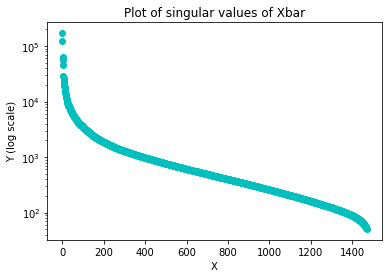

In [14]:
im_bar = im_bar.transpose()
%matplotlib inline
import matplotlib.pyplot as plt
U,s,VT = la.svd(im_bar)
fig = plt.figure()
x = np.arange(s.shape[0])
y = s
ax = fig.add_subplot(111)
plt.yscale('log')
ax.scatter(x, y, c='c', marker='o')
ax.set_title("Plot of singular values of Xbar")
ax.set_xlabel('X')
ax.set_ylabel('Y (log scale)')

In [34]:
#im_bar = im_bar.transpose()
#finding smallest k to encompass 90% of data
s_sum = 0
fnorm = la.norm(im_bar)**2

k = 0
for i in range(s.shape[0]):
    s_sum = s_sum + s[i]**2
    t = s_sum/fnorm
    if(t >= 0.964):
        k = i
        break
#top k principal components of Xbar

print("k is: ",k)

k is:  50


(50, 1470)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6075, 1470)


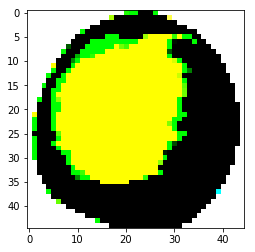

In [35]:
Uk = U[:,0:k]
features = Uk.transpose()@im_bar
print(features.shape)
recon = Uk@Uk.transpose()@im_bar
print(recon.shape)
r = np.random.randint(0,im_bar.shape[1])
img = np.reshape(recon[:,r],(45,45,3))
plt.imshow(img)

### Sklearn PCA

In [15]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in fruits])
print(images_scaled.shape)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

(1470, 6075)


In [16]:
print(pca_result.shape)

(1470, 50)


(1470, 2)


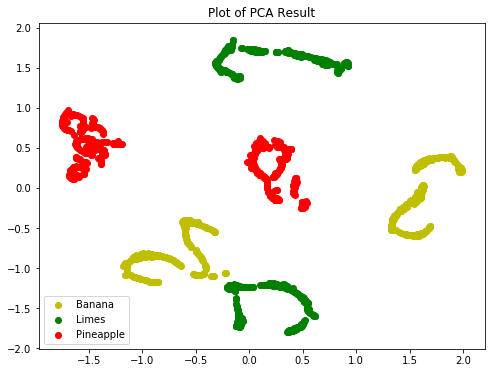

In [17]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

## Split into Training and Test Data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

#### Train Model

In [20]:
svm_clf = svm.SVC(gamma='scale')
svm_clf = svm_clf.fit(X_train, y_train) 

In [21]:
test_predictions = svm_clf.predict(X_test)

In [22]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Training Accuracy with SVM: {0:.6f}".format(precision))

Training Accuracy with SVM: 99.728261


In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(test_predictions, y_test,target_names=label_names))
print(confusion_matrix(test_predictions, y_test, labels=range(3)))

              precision    recall  f1-score   support

      Banana       1.00      0.99      1.00       125
       Limes       1.00      1.00      1.00       117
   Pineapple       0.99      1.00      1.00       126

   micro avg       1.00      1.00      1.00       368
   macro avg       1.00      1.00      1.00       368
weighted avg       1.00      1.00      1.00       368

[[124   0   1]
 [  0 117   0]
 [  0   0 126]]


### Test SVM Model on Validation Data

In [6]:
val_fruits = []
val_labels = [] 
val_fruits_f = []
for fruit_dir in glob.glob("fruits/Test/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        val_fruits.append(img)
        val_fruits_f.append(imgf)
        val_labels.append(fruit_label)
val_fruits = np.array(val_fruits)
val_labels = np.array(val_labels)
val_fruits_f = np.array(val_fruits_f)
print(val_fruits.shape,val_labels.shape)

(498, 45, 45, 3) (498,)


In [27]:
val_label_ids = np.array([label_to_ids[i] for i in val_labels])
val_images_scaled = scaler.transform([i.flatten() for i in val_fruits])
val_pca_res = pca.transform(val_images_scaled)
print(val_pca_res.shape)

(498, 50)


(498, 2)


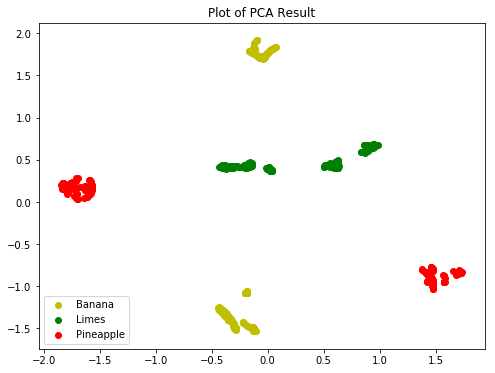

In [30]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(val_pca_res)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (val_label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (val_label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (val_label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

In [31]:
test_predictions = svm_clf.predict(val_pca_res)

In [32]:
precision = accuracy_score(test_predictions, val_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 99.799197
